In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def identify_significant_moves(df, price_col='Close', look_forward=5):
    """ This function now simply calculates future prices and changes without applying a threshold. """
    df['future_price'] = df[price_col].shift(-look_forward)
    df['price_change'] = (df['future_price'] - df[price_col]) / df[price_col]
    return df

def extract_pre_move_conditions(df, probability_columns, days_before=1):
    """ Modified to return price changes along with probabilities. """
    move_indices = df.index[(abs(df['price_change']) > 0.01)].tolist()  # Example threshold for visualization
    pre_move_stats = []
    for idx in move_indices:
        pre_move_idx = idx - days_before
        if pre_move_idx > 0:
            conditions = df.loc[pre_move_idx, probability_columns + ['price_change']]
            pre_move_stats.append(conditions)
    return pd.DataFrame(pre_move_stats)

def process_files(directory_path):
    all_pre_move_conditions = []
    files = os.listdir(directory_path)
    for file_name in files:
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Date'] = pd.to_datetime(df['Date'])
            df = identify_significant_moves(df, 'Close')
            probability_columns = [col for col in df.columns if 'UpProb_Shift' in col]
            pre_move_conditions = extract_pre_move_conditions(df, probability_columns)
            all_pre_move_conditions.append(pre_move_conditions)
    if all_pre_move_conditions:
        combined_pre_move_conditions = pd.concat(all_pre_move_conditions, ignore_index=True)
        return combined_pre_move_conditions
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

# Example usage
directory_path = 'Data/RFpredictions'
combined_pre_move_conditions = process_files(directory_path)
if not combined_pre_move_conditions.empty:
    print(combined_pre_move_conditions.describe())
else:
    print("No significant moves found or no data available.")





def plot_probability_distribution(data, bin_width=0.05):
    """ Plots histograms of UpProb values segmented by price change intervals. """
    intervals = np.arange(-0.1, 0.11, bin_width)
    fig, axes = plt.subplots(nrows=len(intervals)-1, figsize=(10, 20), sharex=True)

    for i in range(len(intervals)-1):
        lower = intervals[i]
        upper = intervals[i+1]
        subset = data[(data['price_change'] >= lower) & (data['price_change'] < upper)]
        ax = axes[i]
        subset['UpProb_Shift_1'].hist(ax=ax, bins=20, alpha=0.7, color='blue')
        ax.set_title(f"Price Change: {lower*100:.1f}% to {upper*100:.1f}%")
        ax.set_xlabel('UpProb_Shift_1')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_probability_distribution(combined_pre_move_conditions)


KeyboardInterrupt: 

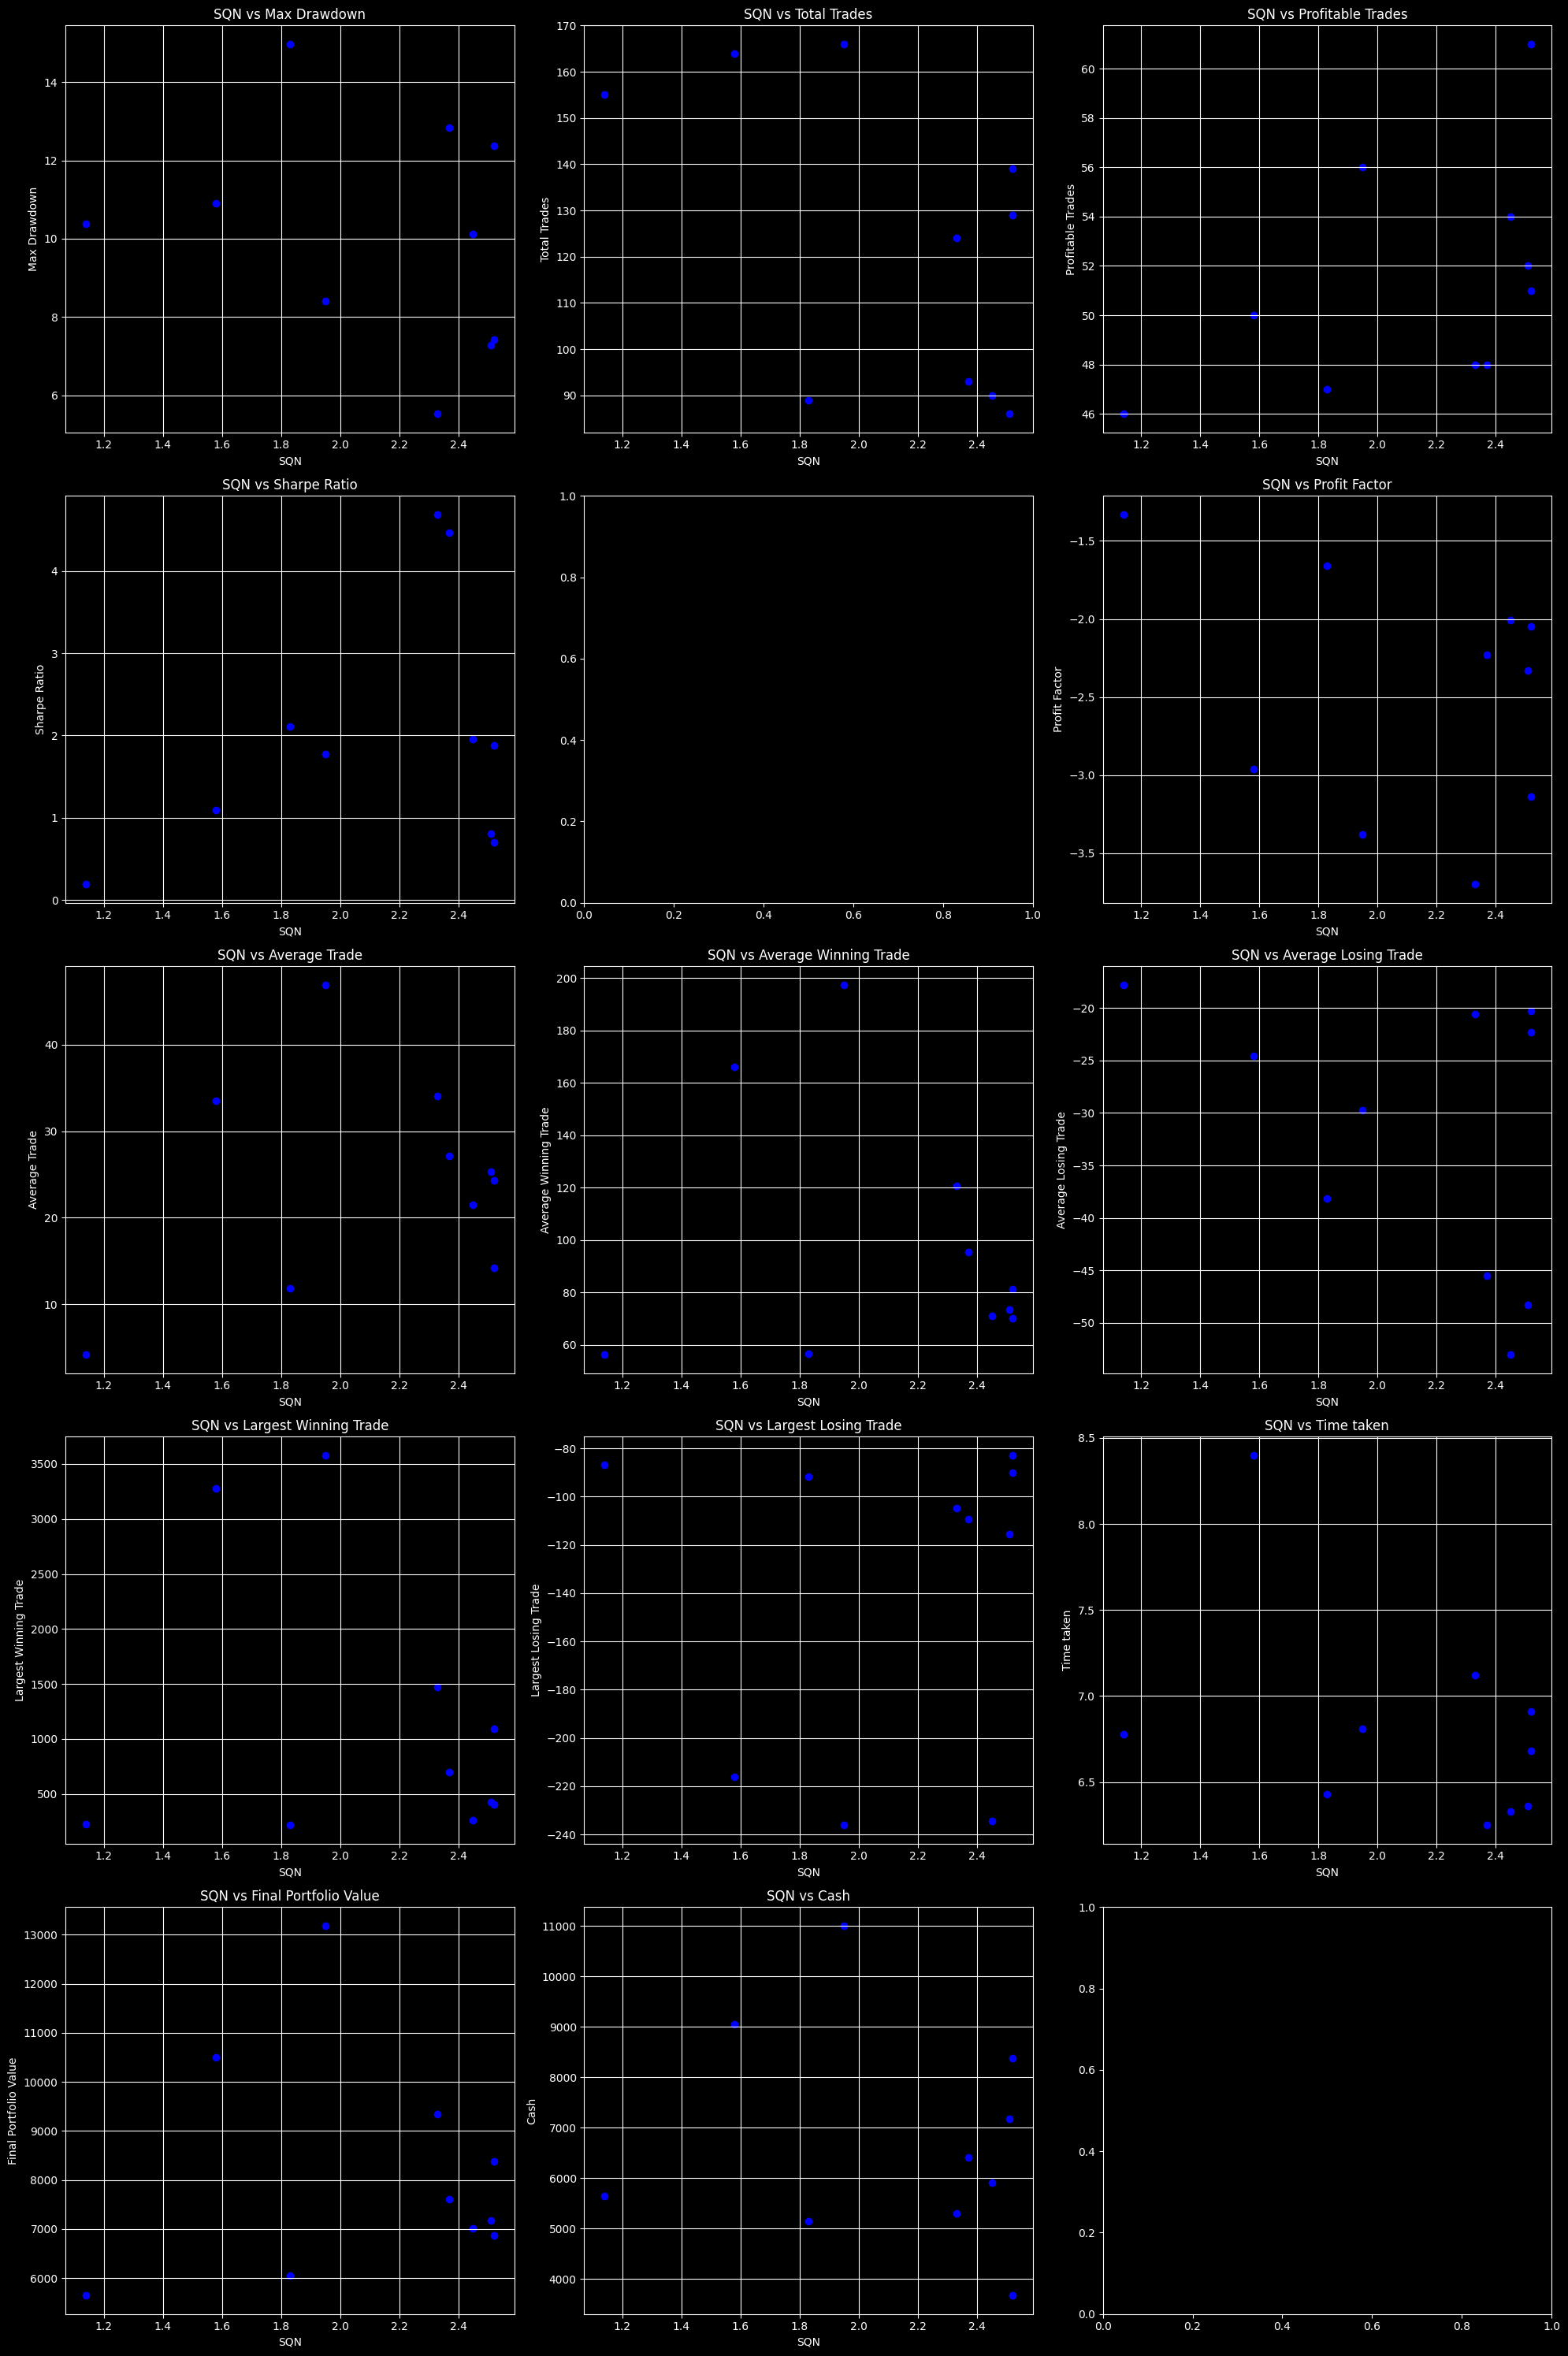

In [3]:
import matplotlib.pyplot as plt
import re

# Path to the log file
log_file_path = "__BrokerLog.log"

# Dictionary to store the data
data = {
    "Max Drawdown": [],
    "Total Trades": [],
    "Profitable Trades": [],
    "Sharpe Ratio": [],
    "SQN": [],
    "Profit Factor": [],
    "Average Trade": [],
    "Average Winning Trade": [],
    "Average Losing Trade": [],
    "Largest Winning Trade": [],
    "Largest Losing Trade": [],
    "Time taken": [],
    "Final Portfolio Value": [],
    "Cash": []
}

# Define regex patterns for each attribute
attribute_patterns = {
    "Max Drawdown": r"Max Drawdown: ([0-9.]+)%",
    "Total Trades": r"Total Trades: ([0-9]+)",
    "Profitable Trades": r"Profitable Trades: ([0-9]+)",
    "Sharpe Ratio": r"Sharpe Ratio: ([0-9.]+)",
    "SQN": r"SQN: ([0-9.]+)",
    "Profit Factor": r"Profit Factor: ([-0-9.]+)",
    "Average Trade": r"Average Trade: ([0-9.]+)",
    "Average Winning Trade": r"Average Winning Trade: ([0-9.]+)",
    "Average Losing Trade": r"Average Losing Trade: ([-0-9.]+)",
    "Largest Winning Trade": r"Largest Winning Trade: ([0-9.]+)",
    "Largest Losing Trade": r"Largest Losing Trade: ([-0-9.]+)",
    "Time taken": r"Time taken: ([0-9.]+) seconds",
    "Final Portfolio Value": r"Final Portfolio Value: \$([0-9,.]+)",
    "Cash": r"Cash: \$([0-9,.]+)"
}

# Read the log file and process each line
with open(log_file_path, 'r') as file:
    for line in file:
        # Check for each attribute and append to the corresponding list
        for attribute, pattern in attribute_patterns.items():
            match = re.search(pattern, line)
            if match:
                value = float(match.group(1).replace(',', '')) if attribute in ["Final Portfolio Value", "Cash"] else float(match.group(1))
                data[attribute].append(value)

# Plotting the data
fig, axs = plt.subplots(5, 3, figsize=(20, 30))  # Corrected subplot grid

for idx, (attribute, values) in enumerate(data.items()):
    if attribute != "SQN":  # Only plot if not SQN vs SQN
        min_length = min(len(values), len(data["SQN"]))
        if min_length > 0:  # Ensure there is data to plot

            ##dark mode this is the only change
            

            ax = axs[idx // 3, idx % 3]  # Corrected subplot indexing
            ax.scatter(data["SQN"][:min_length], values[:min_length], color='blue')
            ax.set_title(f'SQN vs {attribute}')
            ax.set_xlabel('SQN')
            ax.set_ylabel(attribute)
            ax.grid()

fig.tight_layout()
plt.style.use('dark_background')
plt.show()


In [6]:
import os
import pandas as pd

def process_files(directory_path, ticker_list):
    # Convert all tickers in the list to lowercase for case-insensitive comparison
    ticker_set = {ticker.lower() for ticker in ticker_list}
    tickers = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            # Extract the ticker from the filename and convert to lowercase
            ticker = file_name.split('.')[0].lower()
            # Check if the ticker is in the provided list
            if ticker in ticker_set:
                tickers.append(ticker.upper())  # Append the ticker in uppercase to the list                
                tickers.sort()
    return tickers

def create_initial_csv(directory_path, output_file, ticker_list):
    # Extract ticker names from filenames based on the provided list
    tickers = process_files(directory_path, ticker_list)

    columns = [
        'Ticker', 'CurrentlyHolding', 'NumPreviousTrades', 'NumWinningTrades',
        'NumLosingTrades', 'AverageWinningTrade', 'AverageLosingTrade',
        'LargestWinningTrade', 'LargestLosingTrade', 'AverageTrade', 'MaxDrawdown',
        'ProfitFactor', 'SharpeRatio', 'SQN', 'FinalPortfolioValue', 'Cash', 'TimeTaken'
    ]

    df = pd.DataFrame(columns=columns)
    df['Ticker'] = tickers
    df = df.fillna({
        'CurrentlyHolding': False,
        'NumPreviousTrades': 0,
        'NumWinningTrades': 0,
        'NumLosingTrades': 0,
        'AverageWinningTrade': 0,
        'AverageLosingTrade': 0,
        'LargestWinningTrade': 0,
        'LargestLosingTrade': 0,
        'AverageTrade': 0,
        'MaxDrawdown': 0,
        'ProfitFactor': 0,
        'SharpeRatio': 0,
        'SQN': 0,
        'FinalPortfolioValue': 0,
        'Cash': 0,
        'TimeTaken': 0
    })

    # Save to CSV file
    df.to_csv(output_file, index=False)
    print(f"CSV file created at {output_file}")

# Specify the directory and output file
directory_path = 'Data/RFpredictions'
output_file = 'TradingModelStats.csv'
ticker_list = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'TSLA', 'BRK.B', 'JNJ', 'V',
    'WMT', 'JPM', 'PG', 'UNH', 'MA', 'DIS', 'NVDA', 'HD', 'PYPL', 'BAC', 'VZ',
    'ADBE', 'CMCSA', 'NFLX', 'KO', 'PEP', 'INTC', 'T', 'PFE', 'CSCO', 'MRK', 'NKE',
    'XOM', 'ABT', 'WFC', 'ACN', 'ORCL', 'ABBV', 'MCD', 'TXN', 'PM', 'LLY', 'QCOM', 'HON',
    'MDT', 'LIN', 'SBUX', 'DHR', 'MMM', 'LOW', 'UPS'
    ]


# Call the function to create the CSV file
create_initial_csv(directory_path, output_file, ticker_list)


CSV file created at TradingModelStats.csv


/tmp/ipykernel_23353/2310555789.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna({
